Delete all variables in the current environment (if you have already run some cells) - clean state.

In [130]:
%reset

Import all necessary packages.

In [131]:
import networkx as nx
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import shutil
from datetime import datetime
from dateutil import parser
import json
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import math
from kneed import KneeLocator


Replace with the path to the root folder of the project.

In [132]:
rootdir_path = '/home/andreistoica12/research-internship'

Replace with the path to the folder where we store the dataset.

In [133]:
data_path = '/home/andreistoica12/research-internship/data/PhemeDataset'

IMPORTANT NOTE: After running the code, some files from the dataset will be different from the original versions, i.e. the "retweets.json" files inside each story folder were initially invalid. In order to consider and process the retweets in the longitudinal analysis, I formatted these files so that they are valid, parsable JSON files. If the file contained only one retweet object, it has not been modified. If the file contained multiple retweets, the file now contains a list of retweet objects, separated by a comma, as per the JSON syntax.

The paths to the folder containing all subfolders corresponding to each event of major interest (the Charlie Hebdo shooting, footballer Essien having Ebola, etc.). Tweets here are all written in English.

In [134]:
events_path = data_path + "/threads/en"

Create 2 subfolders to store important files and graphs, respectively. If they already existed (from previous runnings of the project), delete the folders and their contents and create empty folders to store the current files and graphs, relevant to the current state of the project.

In [135]:
files_path = os.path.join(rootdir_path, 'files')
if os.path.exists(files_path):
   shutil.rmtree(files_path, ignore_errors=False, onerror=None)
os.makedirs(files_path)

graphs_path = os.path.join(rootdir_path, 'graphs')
if os.path.exists(graphs_path):
   shutil.rmtree(graphs_path, ignore_errors=False, onerror=None)
os.makedirs(graphs_path)

In [136]:
pheme_graphs_path = os.path.join(graphs_path, 'pheme')
if os.path.exists(pheme_graphs_path):
   shutil.rmtree(pheme_graphs_path, ignore_errors=False, onerror=None)
os.makedirs(pheme_graphs_path)

In [137]:
pheme_longitudinal_analysis_graphs = os.path.join(pheme_graphs_path, 'longitudinal-analysis')
if os.path.exists(pheme_longitudinal_analysis_graphs):
   shutil.rmtree(pheme_longitudinal_analysis_graphs, ignore_errors=False, onerror=None)
os.makedirs(pheme_longitudinal_analysis_graphs)

In [138]:
pheme_reaction_times_graphs = os.path.join(pheme_graphs_path, 'reaction-times')
if os.path.exists(pheme_reaction_times_graphs):
   shutil.rmtree(pheme_reaction_times_graphs, ignore_errors=False, onerror=None)
os.makedirs(pheme_reaction_times_graphs)

Here, I define a function that first reads the JSON file and stores it into a dictionary, then parses the date contained at the "created_at" key. The number returned is an integer. 

In [139]:
def tweet_hour(tweet_path):
    with open(tweet_path) as f:
        tweet = json.load(f)
    date = parser.parse(tweet['created_at'])
    
    return date.hour

Function to return the source path, given the story path.

In [140]:
def source_tweet_path(story_path):
    source_dir_path = story_path + "/source-tweets"
    source_path = source_dir_path + "/" + os.listdir(source_dir_path)[0]
    
    return source_path

Function to return a list of all reactions' paths.

In [141]:
def reaction_tweets_paths(story_path):
    reactions_paths_list = []
    reactions_dir_path = story_path + "/reactions"
    for reaction_name in os.listdir(reactions_dir_path):
        reaction_path = reactions_dir_path + "/" + reaction_name
        reactions_paths_list.append(reaction_path)
        
    return reactions_paths_list

Function to validate whether a given JSON file is valid or not. Unmodified retweets files (the ones from teh original dataset) are not valid. We only want ot modify them when they are invalid, otherwise they will become invalid again, as we will have duplicate characters ("[[" / "]]" / ",,") .

In [142]:
def validateJSON(JSON_path):
    try:
        with open(JSON_path, 'r') as file:
            data = json.load(file)
    except ValueError as err:
        return False
    return True

Function to modify/format invalid JSON files for further processing.

In [143]:
def format_retweets_json(retweets_path):
    if not validateJSON(retweets_path):
        with open(retweets_path, 'r') as invalid_json:
            data = invalid_json.read()
        data = "[\n" + data.replace("}\n{", "},\n{") + "]"
        with open(retweets_path,'w') as valid_json:
            valid_json.write(data)

Function to return a list of the hours when all retweets of a specific story have been posted.

In [144]:
def hours_list_retweets(story_path):
    retweets_path = story_path + "/retweets.json"
    hours = []
    if os.path.exists(retweets_path):
        format_retweets_json(retweets_path)
        with open(retweets_path, 'r') as file:
            retweets_list = json.load(file)
        if type(retweets_list) == list:
            hours = [ parser.parse(retweet['created_at']).hour for retweet in retweets_list ]
        else:   # we have this case when the JSON file contains one object, but we need to pass a list forward, so we'll have a 1-length list
            hours = [parser.parse(retweets_list['created_at']).hour]

    return hours

I define a function to store all occurences of dates (only the hours) in a list.

In [145]:
def hours_list_story(story_path):
    # I create a list with all occurences of dates corresponding to the source tweet, reactions (replies) and retweets.
    hours = []

    # source hour
    source_path = source_tweet_path(story_path)
    hour = tweet_hour(source_path)
    hours.append(hour)

    # reactions hours
    reactions_paths_list = reaction_tweets_paths(story_path)
    for reaction_path in reactions_paths_list:
        hour = tweet_hour(reaction_path)
        hours.append(hour)
    
    # retweets hours
    hours.extend(hours_list_retweets(story_path))
    
    return hours

Here, I define a function to return a pandas Series, representing the distribution of the hours of tweets (source tweets, reactions and retweets) posted regarding a specific event given as an input parameter. I chose to convert the list to a pandas Series due to the ease in creating a distribution and corresponding box plot.

In [146]:
def time_distribution_event(event_path):
    hours = []
    for story_id in os.listdir(event_path):
        story_path = event_path + "/" + story_id
        hours.extend(hours_list_story(story_path))
    hours.sort()
    hours_series = pd.Series(hours)
    distribution = hours_series.value_counts()[hours_series.unique()]
    
    return distribution

The following function is delegated to plot the distribution per hour of the tweets sent about a specific topic/event.

In [147]:
def plot_event_distribution(event_name, distribution):
    axes = distribution.plot(kind='bar')
    figure_path = f"{pheme_longitudinal_analysis_graphs}/{event_name}_distribution.png"
    axes.figure.savefig(figure_path)
    plt.close()

Function to plot and save in the local graphs/ folder the distributions corresponding to all events.

In [148]:
def plot_all_event_distributions(events_path):
    for event in os.listdir(events_path):
        event_path = events_path + "/" + event
        distribution = time_distribution_event(event_path)
        plot_event_distribution(event, distribution)

In [149]:
plot_all_event_distributions(events_path)

Computing the reaction times to tweets

In [150]:
deltas_types = ['hours', 'minutes']

Choose between 'hours' and 'minutes' if you want to plot the final graph in hours or minutes
NOTE: This variable needs to have either one of the values in the deltas_types list, otherwise the deltas will be an empty list,
so the plots will make no sense in the end.

In [151]:
deltas_type = deltas_types[0]

In [152]:
def deltas_in_minutes_story(story_path):
    deltas = []
    # Step 1: get t0 datetime object from the source timestamp
    source_path = source_tweet_path(story_path)
    with open(source_path) as file:
        source = json.load(file)
    t0 = parser.parse(source['created_at'])

    # Step 2: for all reactions, get the difference in minutes from the time the source was posted and the time each reaction was posted
    reactions_paths_list = reaction_tweets_paths(story_path)
    for reaction_path in reactions_paths_list:
        with open(reaction_path) as file:
            reaction = json.load(file)
        deltas.append((parser.parse(reaction['created_at']) - t0).total_seconds() / 60)

    # Step 3: for all retweets, get the same time difference in miuntes as above
    retweets_path = story_path + "/retweets.json"
    if os.path.exists(retweets_path):
        format_retweets_json(retweets_path)
        with open(retweets_path, 'r') as file:
            retweets_list = json.load(file)
        if type(retweets_list) == list:
            deltas.extend([ (parser.parse(retweet['created_at']) - t0).total_seconds() / 60 for retweet in retweets_list ])
        else:   # here, the JSON file contains one object, but we need to pass a list forward, so we'll have a 1-length list
            deltas.extend([ (parser.parse(retweets_list['created_at']) - t0).total_seconds() / 60 ])
    
    return deltas

In [153]:
def deltas_event(event_path, deltas_type):
    deltas = []
    if deltas_type == 'hours':
        for story_name in os.listdir(event_path):
            story_path = event_path + "/" + story_name
            deltas.extend([min / 60 for min in deltas_in_minutes_story(story_path)])
    elif deltas_type == 'minutes':
        for story_name in os.listdir(event_path):
            story_path = event_path + "/" + story_name
            deltas.extend(deltas_in_minutes_story(story_path))
    else:
        pass    # TODO: evaluate this case maybe differently

    return deltas

In [154]:
def deltas_all_events(events_path, deltas_type):
    deltas_all_events = {}
    for event_name in os.listdir(events_path):
        event_path = events_path + "/" + event_name
        deltas_all_events[event_name] = deltas_event(event_path, deltas_type)
    
    return deltas_all_events

We need to define the number of clusters we want to have, as it needs to be passed onto the K-Means algorithm. Therefore, one of the easiest methods is to look for the "elbow" point in the plot above, i.e. the point where the rate of decrease in WCSS begins to level off. The optimal number of clusters can be found through teh KneeLocator function within the kneed Python module. Curves with positive concavity are called "elbows", the ones with negative concavity are called "knees". Our K-Means inertia values are decreasing when we increase the number of clusters, because the inertia is calculated by measuring the distance between each data point and its centroid, so having more clusters means points will be closer to their clusters' centroids. So we will have a decreasing convex curve and thus we will pass on this information as arguments in the KneeLocator function.

In [155]:
def knee_elbow_method(deltas):
    wcss = []   # within-cluster sum of squares
    deltas = np.array(deltas)
    deltas = deltas.reshape(-1, 1)
    for k in range(1, 11):  # loop over maximum 10 clusters, as this is a range where you usually find the optimum number of clusters
        kmeans = KMeans(n_clusters=k, n_init="auto", random_state=0)
        kmeans.fit(deltas)
        wcss.append(kmeans.inertia_)

    kn = KneeLocator(range(1, 11), wcss, curve='convex', direction='decreasing')

    # # If you want to visualize the knee point of the graph, you can plot the graph using the following function, 
    # # specifically designed to highlight the knee point
    # kn.plot_knee()

    # # Otherwise, you can plot a graph to your own liking, e.g. the one below
    # # Plot the within-cluster sum of squares against the number of clusters
    # plt.plot(range(1, 11), wcss)
    # plt.title('Elbow Method')
    # plt.xlabel('Number of clusters')
    # plt.ylabel('WCSS')
    # plt.show()

    return kn.knee

In [156]:
def k_means_clustering(k, deltas):
    deltas = np.array(deltas)
    deltas = deltas.reshape(-1, 1)

    # Create a KMeans object with the specified number of clusters
    kmeans = KMeans(n_clusters=k, n_init="auto", random_state=0)
    kmeans.fit(deltas)

    # Get the labels assigned to each data point
    labels = kmeans.labels_

    # Get the centroids of each cluster
    centroids = kmeans.cluster_centers_

    # Print an overview of the resulting clusters
    for i in range(k):
        cluster_data = deltas[labels == i]
        print(f"Cluster {i+1} has {len(cluster_data)} data points and a centroid of {centroids[i][0]}")

    # Create a dictionary to store the clustered data
    clusters_dict = {}
    labels_list = []
    for label in labels:
        labels_list.append(label)
    
    for index, label in enumerate(labels_list):
        if label not in clusters_dict:
            clusters_dict[label] = [deltas[index][0]]
        else:
            clusters_dict[label].append(deltas[index][0])
    
    return clusters_dict

In [157]:
def DBSCAN_clustering(deltas):
    deltas = np.array(deltas)
    deltas = deltas.reshape(-1, 1)

    # Create a DBSCAN object with epsilon=0.3 and minimum samples=5
    dbscan = DBSCAN(eps=0.3, min_samples=5)

    # Fit the DBSCAN object to the data
    dbscan.fit(deltas)

    # Get the labels assigned to each data point
    labels = dbscan.labels_

    # Print the number of clusters and the labels assigned to each data point
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print("Number of clusters:", n_clusters)
    print("Labels:", labels)

    # Create a dictionary to store the clusters
    clusters_dict = {}
    for i, label in enumerate(labels):
        if label in clusters_dict:
            clusters_dict[label].append(deltas[i][0])
        else:
            clusters_dict[label] = [deltas[i][0]]
    
    return clusters_dict

In [158]:
def clusters_all_events(events_path, deltas_type):
    all_events_deltas = deltas_all_events(events_path, deltas_type)
    all_events_clusters = {}
    for event_name, event_deltas in all_events_deltas.items():
        # k = knee_elbow_method(event_deltas)
        # print(f"\nEvent {event_name}:")
        # print(f"NOTE: Numbers represent {deltas_type}\n")
        # all_events_clusters[event_name] = k_means_clustering(k, event_deltas)

        all_events_clusters[event_name] = DBSCAN_clustering(event_deltas)

        
    return all_events_clusters


In [159]:
# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

In [160]:
def plot_reaction_times(events_path, deltas_type):
    all_clusters = clusters_all_events(events_path, deltas_type)

    for event_name, clusters in all_clusters.items():
        clusters_for_plot = {}
        for key, value in clusters.items():
            clusters_for_plot[f"{math.floor(min(value))} - {math.ceil(max(value))}"] = len(value)

        intervals_unsorted = list(clusters_for_plot.keys())
        values_unsorted = list(clusters_for_plot.values())
        df_plot = pd.DataFrame(
            dict(
                Interval=intervals_unsorted,
                Value=values_unsorted
            )
        )
        
        df_plot['Start of interval'] = df_plot['Interval'].str.split(' - ').str[0]
        df_plot['Start of interval'] = df_plot['Start of interval'].apply(pd.to_numeric) 
        df_plot_sorted = df_plot.sort_values('Start of interval')
        intervals = list(df_plot_sorted['Interval'])
        values = list(df_plot_sorted['Value'])


        # # calling the function to add value labels
        # addlabels(intervals, values)
        plt.bar(range(len(clusters_for_plot)), values, tick_label=intervals)
        plt.title(f'Distribution of reaction times in {deltas_type}')
        plt.xlabel(f'Reaction times (between x and y {deltas_type})')
        plt.ylabel('Number of reactions')
        plt.savefig(pheme_reaction_times_graphs + f"/{event_name}_reaction_times.png")
        plt.close()

In [161]:
plot_reaction_times(events_path, deltas_type)

Number of clusters: 12
Labels: [-1  0  1 ...  1  1  3]
Number of clusters: 6
Labels: [0 0 0 ... 0 0 0]
Number of clusters: 11
Labels: [ 0  0  0 ... -1 -1  3]
Number of clusters: 5
Labels: [0 0 0 ... 0 0 0]
Number of clusters: 18
Labels: [ 0  0  0 ...  0  0 12]
Number of clusters: 2
Labels: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0 -1  1  1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0 -1 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  1  1  0  1  1  0  0  0  0  0  0  0  0 -1  0
  0  0  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Number of clusters: 4
Labels: [ 0  0  0  0  0  0  0  0

In [162]:
# TODO: see how to make K-Means have all uninterfering deltas (if I can even do that)
# (e.g. in cluser 1, centroid 2, there is a delta of 4.4 and in cluster 2, centroid 15, there is a delta of 3.3)

In [163]:
# TODO: document new functions, explain how I sorted the columns in graphs for all events

In [164]:
# TODO: see what DBSCAN does exactly and how it is different than K-Means (we can see sub clusters, we usually have more clusters etc.)
# TODO: integrate it better in the code

In [165]:
# TODO: improve visualization for BDSCAN - labels are not clear enough

In [166]:
all_clusters = clusters_all_events(events_path, deltas_type)

Number of clusters: 12
Labels: [-1  0  1 ...  1  1  3]
Number of clusters: 6
Labels: [0 0 0 ... 0 0 0]
Number of clusters: 11
Labels: [ 0  0  0 ... -1 -1  3]
Number of clusters: 5
Labels: [0 0 0 ... 0 0 0]
Number of clusters: 18
Labels: [ 0  0  0 ...  0  0 12]
Number of clusters: 2
Labels: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0 -1  1  1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0 -1 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  1  1  0  1  1  0  0  0  0  0  0  0  0 -1  0
  0  0  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Number of clusters: 4
Labels: [ 0  0  0  0  0  0  0  0

In [167]:
all_clusters['germanwings-crash']

{-1: [46.96805555555556,
  56.26583333333333,
  46.2275,
  15.894166666666667,
  46.98611111111111,
  49.708333333333336,
  15.595277777777778,
  20.490000000000002,
  20.910833333333336,
  37.24333333333333,
  52.15555555555556,
  55.58277777777778,
  81.80055555555556,
  105.19277777777778,
  127.10527777777777,
  13.742222222222221,
  19.29388888888889,
  19.853055555555557,
  20.350833333333334,
  24.730277777777776,
  24.888333333333332,
  25.258888888888887,
  27.809444444444445,
  31.753611111111113,
  37.43777777777778,
  44.6775,
  56.995555555555555,
  33.75472222222222,
  43.84,
  54.26694444444445,
  15.176111111111112,
  15.204444444444444,
  15.350277777777778,
  23.58388888888889,
  23.81222222222222,
  24.04861111111111,
  29.581666666666667,
  30.66611111111111,
  31.302222222222223,
  31.91611111111111,
  31.93111111111111,
  33.602222222222224,
  34.2625,
  36.31111111111111,
  40.89194444444445,
  58.46472222222222,
  62.95722222222222,
  201.00222222222223,
  63.39

In [168]:
all_reactions = []
all_reactions.extend(all_clusters['germanwings-crash'][0])
all_reactions.extend(all_clusters['germanwings-crash'][1])
all_reactions.extend(all_clusters['germanwings-crash'][2])

In [169]:
type(all_reactions)

list

(array([1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([57.55222222, 57.5596    , 57.56697778, 57.57435556, 57.58173333,
        57.58911111, 57.59648889, 57.60386667, 57.61124444, 57.61862222,
        57.626     , 57.63337778, 57.64075556, 57.64813333, 57.65551111,
        57.66288889, 57.67026667, 57.67764444, 57.68502222, 57.6924    ,
        57.69977778, 57.70715556, 57.71453333, 57.72191111, 57.72928889,
        57.73666667, 57.74404444, 57.75142222, 57.7588    , 57.76617778,
        57.77355556, 57.78093333, 57.78831111, 57.79568889, 57.80306667,
        57.81044444, 57.81782222, 57.8252    , 57.83257778, 57.83995556,
        57.84733333, 57.85471111, 57.86208889, 57.86946667, 57.87684444,
        57.88422222, 57.8916    , 57.89897778, 57.90635556, 57.91373333,
        57.92111111]),
 <BarContainer object

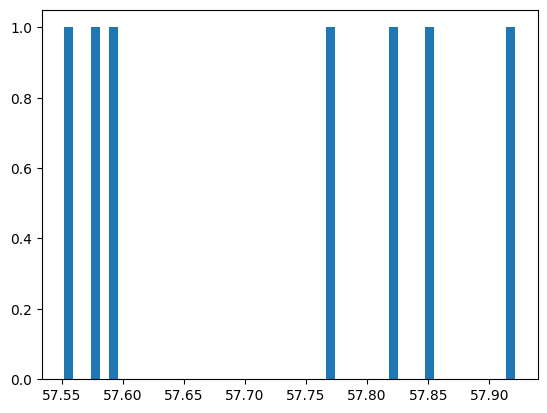

In [170]:
plt.hist(all_clusters['germanwings-crash'][2], bins=50)